In [1]:
import os
from os import listdir
from os.path import isfile,join
import numpy as np
import matplotlib.pyplot as plt

In [42]:
#This is just setting up my filepaths; you should replace them with wherever your folders are

path_low_darks = 'C:/Users/Dillon/Desktop/CRED-2_Data/Low_Gain/Darks (FPS)/'
path_low_flats = 'C:/Users/Dillon/Desktop/CRED-2_Data/Low_Gain/Flats (65 FPS)/'
path_low_lin = 'C:/Users/Dillon/Desktop/CRED-2_Data/Low_Gain/Linearity Images (FPS)/'

darks_folders = sorted(listdir(path_low_darks), key = lambda x: int(os.path.splitext(x)[0]))
lin_folders = sorted(listdir(path_low_lin), key = lambda x: int(os.path.splitext(x)[0]))

flat_files = [f for f in listdir(path_low_flats) if isfile(join(path_low_flats, f))]

print (darks_folders)
print (lin_folders)
print (flat_files)

['35', '45', '55', '65', '75', '85', '95', '105', '115', '125', '135', '145', '155', '165', '175', '185', '195', '205', '215', '225']
['35', '45', '55', '65', '75', '85', '95', '105', '115', '125', '135', '145', '155', '165', '175', '185', '195', '205', '215', '225']
['frame977392.raw', 'frame977393.raw', 'frame977394.raw', 'frame977395.raw', 'frame977396.raw', 'frame977397.raw', 'frame977398.raw', 'frame977399.raw', 'frame977400.raw', 'frame977401.raw', 'frame977402.raw', 'frame977403.raw', 'frame977404.raw', 'frame977405.raw', 'frame977406.raw', 'frame977407.raw', 'frame977408.raw', 'frame977409.raw', 'frame977410.raw', 'frame977411.raw', 'frame977412.raw', 'frame977413.raw', 'frame977414.raw', 'frame977415.raw', 'frame977416.raw', 'frame977417.raw', 'frame977418.raw', 'frame977419.raw', 'frame977420.raw', 'frame977421.raw', 'frame977422.raw', 'frame977423.raw', 'frame977424.raw', 'frame977425.raw', 'frame977426.raw', 'frame977427.raw', 'frame977428.raw', 'frame977429.raw', 'frame977

## Creating Master Dark frames for each exposure time

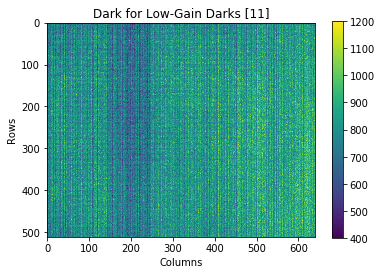

811.0090627441406
111.82165596677736


In [78]:
#This code just runs through the files in each folder for the darks, and creates a master dark for each FPS

array_list_darks = []     # This is the final output of this block

for folders in darks_folders:
    
    folder_path = path_low_darks + folders
    filenames = [f for f in listdir(folder_path) if isfile(join(folder_path, f))]
    
    temp_array_list = []
    
    for frames in filenames:
    
        img_file = folder_path + '/' + frames
        arraytype = np.fromfile(img_file, dtype = np.int16)
        arraytype.shape = (512, 640)
        temp_array_list.append(arraytype)
        
    mean_dark = np.mean(temp_array_list, axis = 0)    #Can change this to median if wanted
    
    array_list_darks.append(mean_dark)

# We now have array_list_darks, which is a list of master dark arrays from 35 to 225 FPS (20) created by MEAN
# A quick look at one of the darks

dark_plot = plt.figure()
dark_plot.add_axes()
plt.title('Dark for Low-Gain Darks [11]')
plt.xlabel('Columns')
plt.ylabel('Rows')
dark_plot = plt.imshow(array_list_darks[11], cmap = 'viridis', interpolation = 'nearest')
plt.colorbar(dark_plot)
plt.clim(400, 1200)

plt.show(dark_plot)
print (np.mean(array_list_darks[11]))
print (np.std(array_list_darks[11]))

#They really all look the same

## Creating the Master Flat

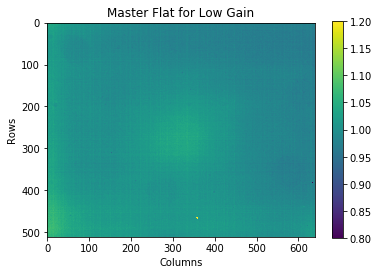

0.9999999999999998
0.020141689087780835


In [79]:
#This code just creates a master flat (dark subtracted), and then normalizes it
master_flat_array = []

for frames in flat_files:
    
    img_file = path_low_flats + frames
    arraytype = np.fromfile(img_file, dtype = np.int16)
    arraytype.shape = (512, 640)
    arraytype = arraytype - array_list_darks[3]        #Subtracting the darks of the corresponding FPS (65)
    master_flat_array.append(arraytype)
    
master_flat = np.mean(master_flat_array, axis = 0)     #Can change this to MEDIAN if wanted
master_flat = master_flat / np.mean(master_flat)
# We now have a master flat frame, with darks subtracted and then AVERAGED

flat_plot = plt.figure()
flat_plot.add_axes()
plt.title('Master Flat for Low Gain')
plt.xlabel('Columns')
plt.ylabel('Rows')
flat_plot = plt.imshow(master_flat, cmap = 'viridis', interpolation = 'nearest')
plt.colorbar(flat_plot)
plt.clim(0.8, 1.2)

plt.show(flat_plot)
print (np.mean(master_flat))
print (np.std(master_flat))

## Reducing the "Science" Images

In [80]:
#This reduces the combined science images of each FPS with the darks of each respective FPS, and then divides by the
#master flat. It also records the mean and variances of each final science image to make a rudimentary gain plot

array_list_lin = []     # This is the final output of this block

mean_list = []
variance_list = []
for i, folders in enumerate(lin_folders):
    
    folder_path = path_low_lin + folders
    filenames = [f for f in listdir(folder_path) if isfile(join(folder_path, f))]
    
    temp_array_list = []
    
    for frames in filenames:
    
        img_file = folder_path + '/' + frames
        arraytype = np.fromfile(img_file, dtype = np.int16)
        arraytype.shape = (512, 640)
        temp_array_list.append(arraytype)
        
    mean_lin = np.mean(temp_array_list, axis = 0)    #Can change this to median if wanted
    
    #Doing the reduction in this step, replacing divide by 0s with 0s
    
    a = mean_lin - array_list_darks[i]
    final_lin = np.divide(a, master_flat, out = np.zeros_like(a), where = master_flat != 0)
    
    mean_list.append(np.mean(final_lin))
    variance_list.append(np.std(final_lin) ** 2.0)
    
    array_list_lin.append(final_lin)

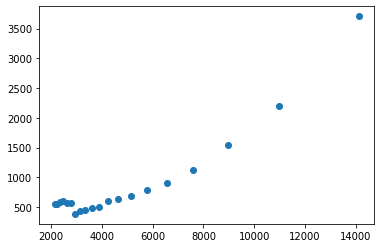

In [66]:
plt.scatter(mean_list, variance_list)

In [81]:
#Calculates a linear fit for the slope
equation_fit = np.polyfit(mean_list, variance_list, 1)
print (equation_fit)

print ('The gain is the inverse of the slope, which gives us ' + str(1.0 / equation_fit[0]))

[ 2.29268077e-01 -2.47161200e+02]
The gain is the inverse of the slope, which gives us 4.361706234177038


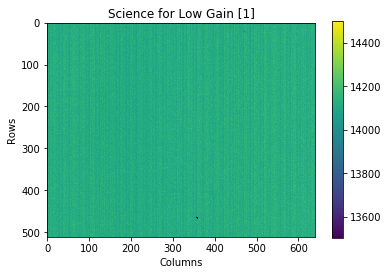

In [82]:
#Just looking at one of the science images (reduced)
lin_plot = plt.figure()
lin_plot.add_axes()
plt.title('Science for Low Gain [1]')
plt.xlabel('Columns')
plt.ylabel('Rows')
lin_plot = plt.imshow(array_list_lin[0], cmap = 'viridis', interpolation = 'nearest')
plt.colorbar(lin_plot)
plt.clim(13500, 14500)

plt.show(lin_plot)